In [1]:
import sys; sys.path.append("../")
import numpy as np
from matplotlib import pyplot as plt

from backend.utils import *
from backend.processing import *
image = readvol("../datasets/image.h5")
label = readvol("../datasets/label.h5")
print(image.shape, image.dtype)
print(label.shape, label.dtype)
syn, seg = process_syn(label)

(100, 700, 700) uint8
(100, 700, 700) uint8


In [2]:
def plot_regression_line(crop_size, slope):
    center = crop_size // 2
    coord_y1 = np.array([5, crop_size-5])
    coord_x1 = (coord_y1-center) * slope + center
    
    denominator = max(slope, 1e-4) if slope>=0 else min(slope, -1e-4)
    coord_x2 = np.array([5, crop_size-5])
    coord_y2 = (coord_x2-center) / denominator + center
    if (coord_x1>=0).all():
        plt.plot(coord_x1, coord_y1, "--r", linewidth=3)
    else:
        plt.plot(coord_x2, coord_y2, "--r", linewidth=3)
        
def rotate_both(cropped_img, cropped_syn, angle):
    img_dtype, syn_dtype = cropped_img.dtype, cropped_syn.dtype
    cropped_img = cropped_img.astype(np.float32)
    cropped_syn = cropped_syn.astype(np.float32)
    rotate_img, rotate_syn, angle = rotateIm_polarity(cropped_img, cropped_syn, -angle)
    rotate_img = rotate_img.astype(img_dtype)
    rotate_syn = rotate_syn.astype(syn_dtype)
    return rotate_img, rotate_syn

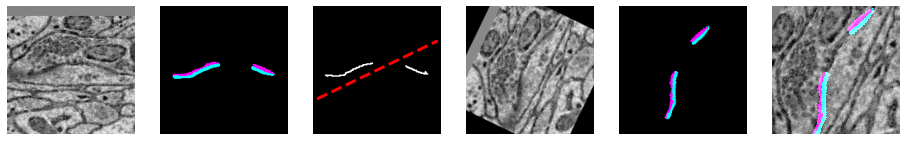

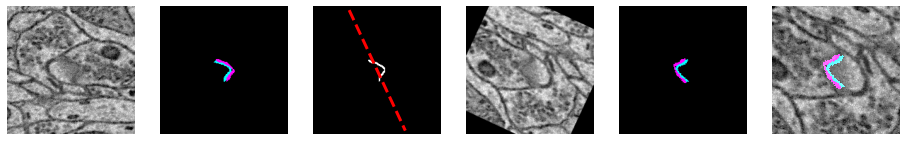

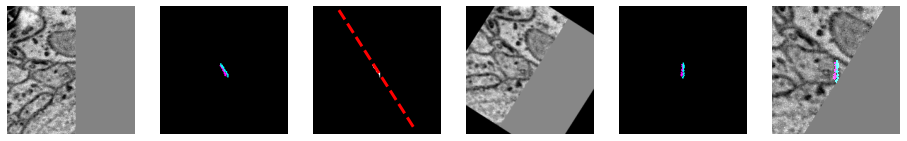

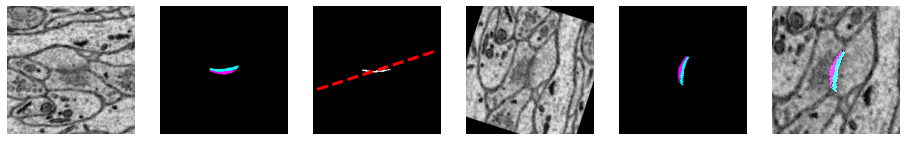

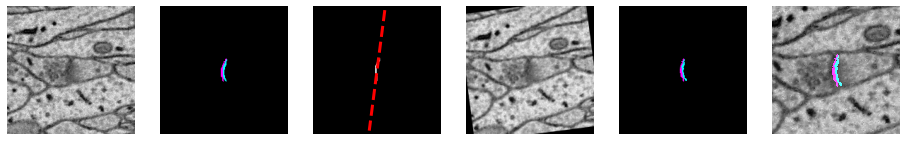

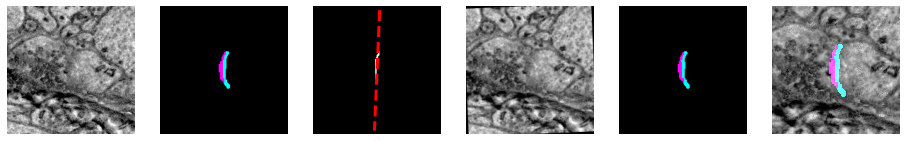

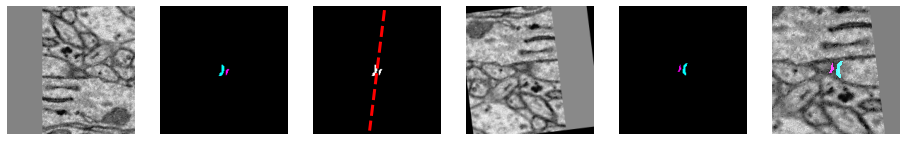

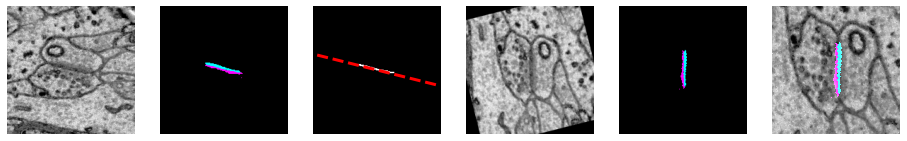

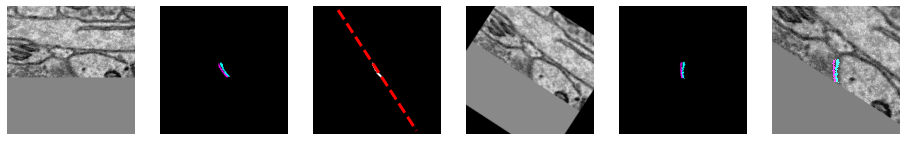

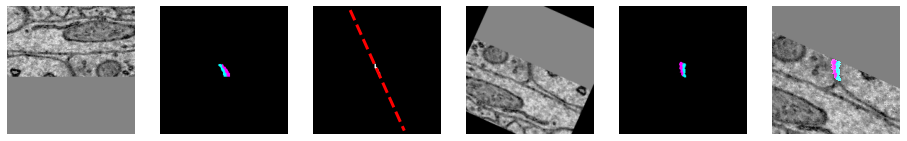

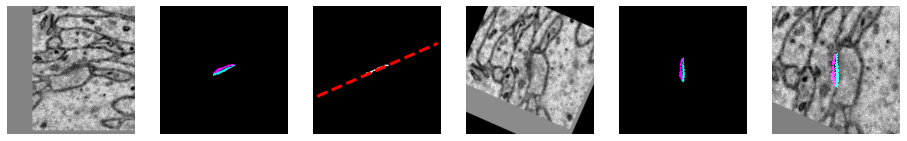

In [3]:
out_size = 128
crop_size = int(out_size * 1.415)
seg_idx = np.unique(seg)[1:] # ignore background
for i, idx in enumerate(seg_idx):
    temp = (seg == idx)
    bbox = bbox2_ND(temp)
    z_mid = (bbox[0] + bbox[1]) // 2 # middle slice in 3D volume
    
    temp_2d = temp[z_mid]      
    bbox_2d = bbox2_ND(temp_2d)  
    
    y1, y2 = adjust_bbox(bbox_2d[0], bbox_2d[1], crop_size)
    x1, x2 = adjust_bbox(bbox_2d[2], bbox_2d[3], crop_size)
    crop_2d = [y1, y2, x1, x2]

    cropped_syn, syn_bbox, padding = crop_pad_data(syn, z_mid, crop_2d, mask=temp, return_box=True)
    cropped_img = crop_pad_data(image, z_mid, crop_2d, pad_val=128)
  
    angle, slope, overlap = calculate_rot(cropped_syn, return_overlap=True, mode='linear')
    rotate_img, rotate_syn = rotate_both(cropped_img, cropped_syn, angle)
    
    # composite of image and label
    composite = np.stack([rotate_img for _ in range(3)], axis=2)
    composite = np.maximum(composite, syn2rgb(rotate_syn))
    composite = center_crop(composite, out_size)
    
    # visualization
    plt.figure(figsize=(16,4))
    plt.subplot(161);plt.imshow(cropped_img, cmap='gray');plt.axis("off")
    plt.subplot(162);plt.imshow(syn2rgb(cropped_syn));plt.axis("off")     
    plt.subplot(163);plt.imshow(overlap, cmap='gray');plt.axis("off")
    plot_regression_line(crop_size, slope)
    
    plt.subplot(164);plt.imshow(rotate_img, cmap='gray');plt.axis("off")
    plt.subplot(165);plt.imshow(syn2rgb(rotate_syn));plt.axis("off")
    plt.subplot(166);plt.imshow(composite);plt.axis("off")
    plt.show()
    
    if i >= 10: break